In [61]:

import numpy 
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline
pandas.__version__

u'0.18.1'

In [4]:
numpy.random.seed(7)

   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0                                                112                             
1                                                118                             
2                                                132                             
3                                                129                             
4                                                121                             


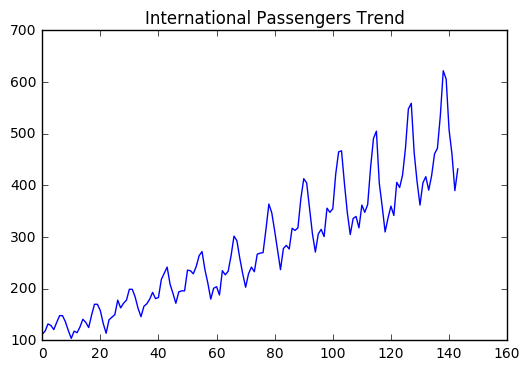

In [5]:
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
print dataframe.head()
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.title("International Passengers Trend")
plt.show()

In [47]:

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print"Length of Training data is %d and Test data is %d" %(len(train), len(test))


Length of Training data is 96 and Test data is 48


In [48]:
'''
Create the dataset by making x(t) as X and x(t+1) as Y

'''
def create_dataset(data_set,look_back):
    X=[]
    Y=[]
    for i in range(len(data_set)-look_back-1):
        curr = numpy.ravel(data_set[i:(i+look_back)])
        X.append(curr)
        nxt = data_set[i+look_back]
        
        Y.append(nxt)
    #print numpy.hstack((numpy.asanyarray(X),numpy.asanyarray(Y)))
    return numpy.array(X),numpy.array(Y)
    

In [55]:
tr_X,tr_Y=create_dataset(train,look_back=2)

In [56]:
tst_X,tst_Y=create_dataset(test,look_back=2)

In [57]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(tr_X, (tr_X.shape[0], 1, tr_X.shape[1]))
testX = numpy.reshape(tst_X, (tst_X.shape[0], 1, tst_X.shape[1]))

In [58]:

# create and fit the LSTM network
look_back=2
model = Sequential()
model.add(LSTM(16, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, tr_Y, nb_epoch=100, batch_size=2, verbose=1)

Epoch 1/100
93/93 [==============================] - 5s - loss: 0.0348     
Epoch 2/100
93/93 [==============================] - 4s - loss: 0.0139     
Epoch 3/100
93/93 [==============================] - 4s - loss: 0.0093     
Epoch 4/100
93/93 [==============================] - 4s - loss: 0.0083     
Epoch 5/100
93/93 [==============================] - 4s - loss: 0.0074     
Epoch 6/100
93/93 [==============================] - 5s - loss: 0.0066     
Epoch 7/100
93/93 [==============================] - 5s - loss: 0.0059     
Epoch 8/100
93/93 [==============================] - 4s - loss: 0.0054     
Epoch 9/100
93/93 [==============================] - 4s - loss: 0.0050     
Epoch 10/100
93/93 [==============================] - 4s - loss: 0.0046     
Epoch 11/100
93/93 [==============================] - 4s - loss: 0.0042     
Epoch 12/100
93/93 [==============================] - 4s - loss: 0.0040     
Epoch 13/100
93/93 [==============================] - 4s - loss: 0.0038     
Epoch 14

In [324]:
#import theano; print(theano.config)

In [325]:
THEANO_FLAGS='floatX=float32,device=gpu0,lib.cnmem=1'

In [59]:

# make predictions
trainScore=0.0
testScore=0.0
trainPredict = model.predict(trainX)

testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
tr_Y = scaler.inverse_transform(tr_Y)
testPredict = scaler.inverse_transform(testPredict)
tst_Y = scaler.inverse_transform(tst_Y)
# calculate root mean squared error
#print len(trainPredict)
#print len(trainY)
#s= numpy.subtract(trainPredict,tr_Y)**2
#print numpy.sum(numpy.sqrt(s))/len(tr_Y)

trainScore = math.sqrt(mean_squared_error(tr_Y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(tst_Y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.08 RMSE


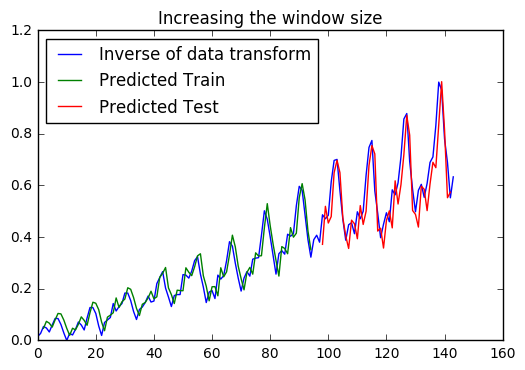

In [60]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.title("Increasing the window size")
plt.plot(scaler.inverse_transform(dataset),label="Inverse of data transform")
plt.plot(trainPredictPlot,label="Predicted Train")
plt.plot(testPredictPlot,label="Predicted Test")
plt.legend(loc=0)
plt.show()